In [31]:
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
import hiive.mdptoolbox.mdp as mdp
import numpy as np
np.random.seed(42)
import time
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import gym
from scipy.stats import poisson
import mdptoolbox
from algorithms.rl import RL
from examples.test_env import TestEnv
from examples.plots import Plots
from algorithms.planner import Planner

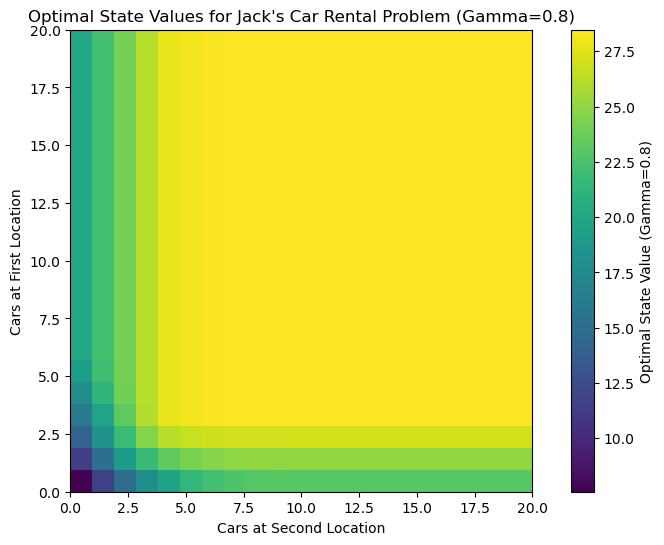

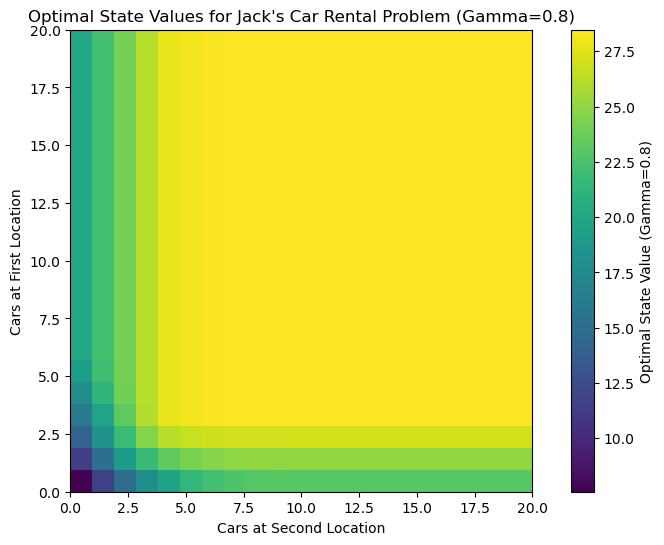

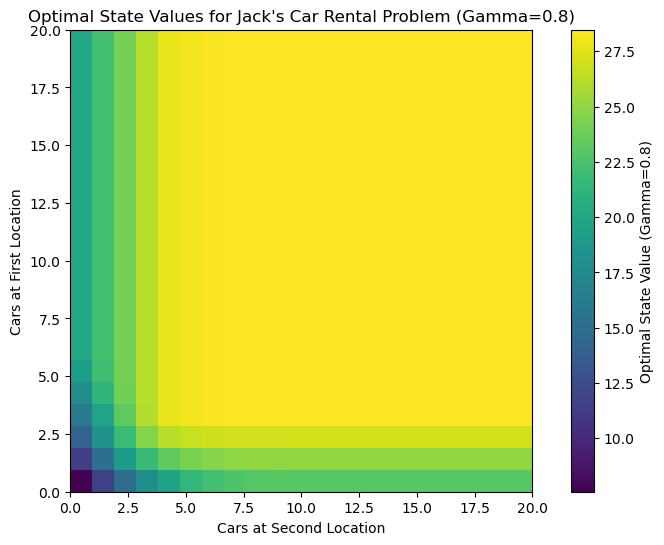

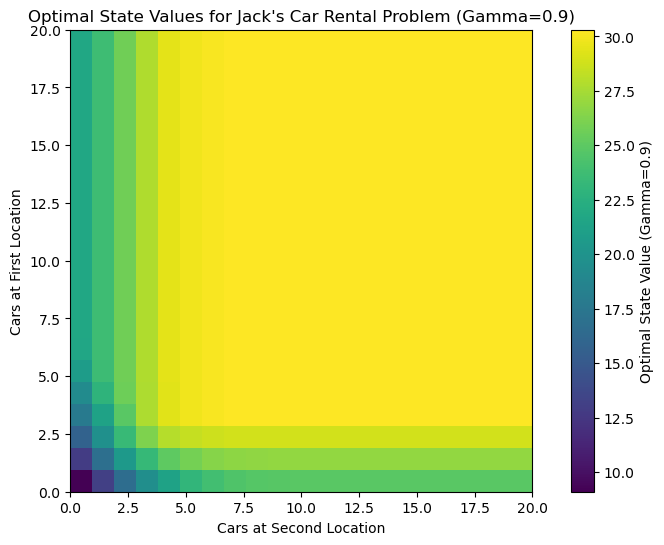

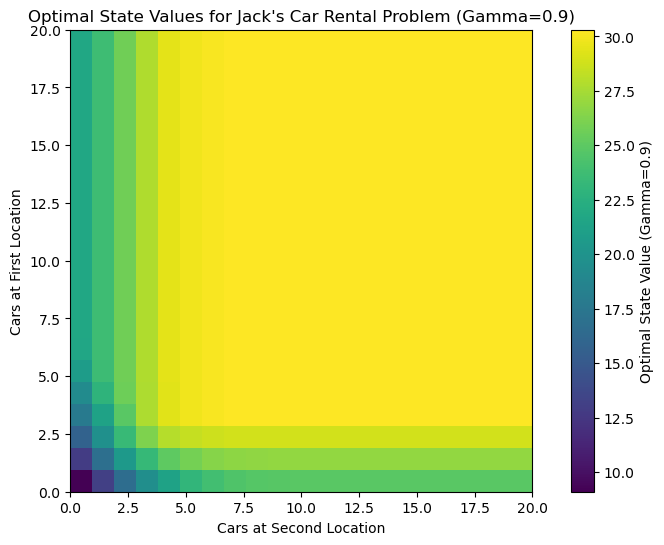

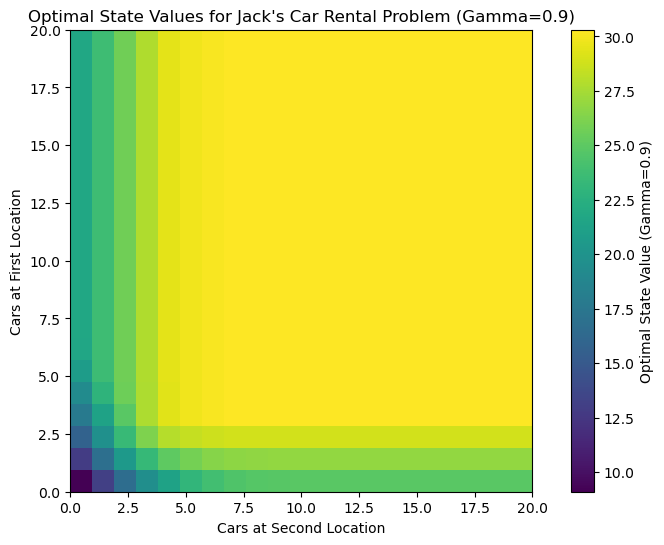

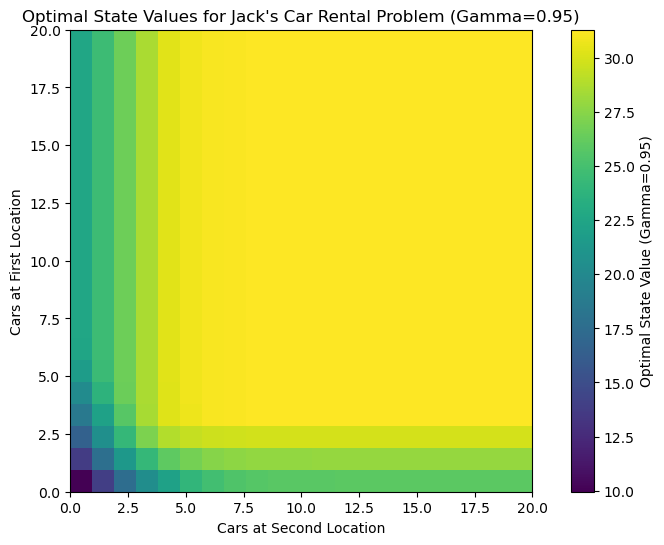

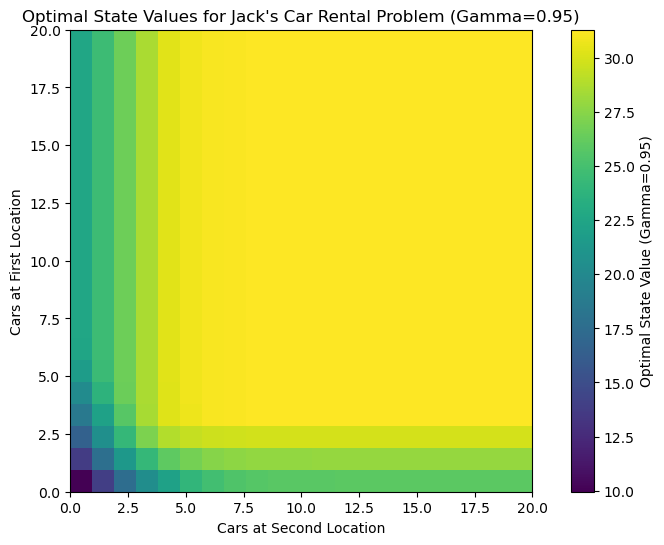

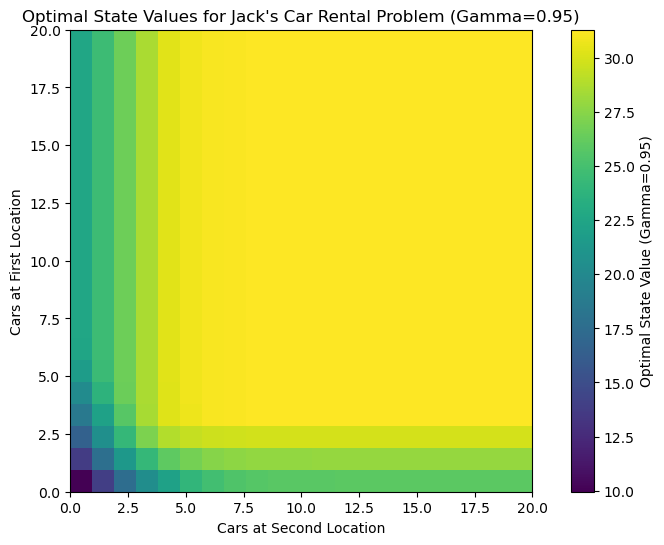

ValueError: setting an array element with a sequence.

In [160]:
%%time

# Constants
MAX_CARS = 20
RENTAL_CREDIT = 10
MOVE_COST = 2
RENTAL_REQUEST_FIRST_LOC = 3
RENTAL_REQUEST_SECOND_LOC = 4
RETURNS_FIRST_LOC = 3
RETURNS_SECOND_LOC = 2
MAX_MOVE = 5
MAX_EPISODES = 10000
LEARNING_RATE = 0.1
EXPLORATION_PROB = 0.1

states = [(i, j) for i in range(MAX_CARS + 1) for j in range(MAX_CARS + 1)]

# Experiment with multiple gamma values
gamma_values = [0.8, 0.9, 0.95]
epsilon_values = [1e-5, 1e-6, 1e-7]
for gamma in gamma_values:
    DISCOUNT_FACTOR = gamma
    for epsilon in epsilon_values:
        EPSILON = epsilon
        # Value Iteration
        def expected_return(state, action, state_value):
            returns = 0.0
            returns -= MOVE_COST * abs(action)

            for req_first_loc in range(0, RENTAL_REQUEST_FIRST_LOC + 1):
                for req_second_loc in range(0, RENTAL_REQUEST_SECOND_LOC + 1):
                    prob = (np.math.pow(RENTAL_REQUEST_FIRST_LOC, req_first_loc) *
                            np.math.exp(-RENTAL_REQUEST_FIRST_LOC) /
                            np.math.factorial(req_first_loc) *
                            np.math.pow(RENTAL_REQUEST_SECOND_LOC, req_second_loc) *
                            np.math.exp(-RENTAL_REQUEST_SECOND_LOC) /
                            np.math.factorial(req_second_loc))

                    num_cars_first_loc = min(state[0] - action, MAX_CARS)
                    num_cars_second_loc = min(state[1] + action, MAX_CARS)

                    valid_rent_first_loc = min(num_cars_first_loc, req_first_loc)
                    valid_rent_second_loc = min(num_cars_second_loc, req_second_loc)

                    reward = (valid_rent_first_loc + valid_rent_second_loc) * RENTAL_CREDIT
                    num_cars_first_loc -= valid_rent_first_loc
                    num_cars_second_loc -= valid_rent_second_loc

                    num_cars_first_loc = min(num_cars_first_loc + RETURNS_FIRST_LOC, MAX_CARS)
                    num_cars_second_loc = min(num_cars_second_loc + RETURNS_SECOND_LOC, MAX_CARS)

                    returns += prob * (reward + DISCOUNT_FACTOR * state_value[num_cars_first_loc, num_cars_second_loc])

            return returns

        def value_iteration():
            state_value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

            while True:
                delta = 0
                for state in states:
                    old_value = state_value[state]
                    action_values = []
                    for action in range(-MAX_MOVE, MAX_MOVE + 1):
                        if (action >= 0 and state[0] >= action) or (action < 0 and state[1] >= abs(action)):
                            action_values.append(expected_return(state, action, state_value))
                    state_value[state] = max(action_values)
                    delta = max(delta, abs(old_value - state_value[state]))

                if delta < EPSILON:
                    break

            return state_value

        # Run Value Iteration
        optimal_state_values = value_iteration()

        # Create Pandas DataFrame for Value Iteration
        df_value_iteration = pd.DataFrame(optimal_state_values, index=range(MAX_CARS + 1), columns=range(MAX_CARS + 1))

        # Create Relevant Graphs and Charts for Value Iteration
        plt.figure(figsize=(10, 6))
        plt.imshow(df_value_iteration, origin='lower', cmap='viridis', extent=(0, MAX_CARS, 0, MAX_CARS))
        plt.colorbar(label=f'Optimal State Value (Gamma={gamma})')
        plt.title(f'Optimal State Values for Jack\'s Car Rental Problem (Gamma={gamma}, Epsilon={epsilon})')
        plt.xlabel('Cars at Second Location')
        plt.ylabel('Cars at First Location')
        plt.show()


In [176]:
%%time

# Constants
MAX_CARS = 20
RENTAL_CREDIT = 10
MOVE_COST = 2
RENTAL_REQUEST_FIRST_LOC = 3
RENTAL_REQUEST_SECOND_LOC = 4
RETURNS_FIRST_LOC = 3
RETURNS_SECOND_LOC = 2
MAX_MOVE = 5
MAX_EPISODES = 10000
LEARNING_RATE = 0.1
EXPLORATION_PROB = 0.1

# States
states = [(i, j) for i in range(MAX_CARS + 1) for j in range(MAX_CARS + 1)]

# Experiment with multiple gamma values
gamma_values = [0.1, 0.5, 0.8, 0.9]
epsilon_values = [1e-5, 1e-6]

# Data storage
results_data = []

for gamma in gamma_values:
    DISCOUNT_FACTOR = gamma
    for epsilon in epsilon_values:
        EPSILON = epsilon
        LEARNING_RATE = 0.5

        # Value Iteration
        def expected_return(state, action, state_value):
            returns = 0.0
            returns -= MOVE_COST * abs(action)

            for req_first_loc in range(0, RENTAL_REQUEST_FIRST_LOC + 1):
                for req_second_loc in range(0, RENTAL_REQUEST_SECOND_LOC + 1):
                    prob = (np.math.pow(RENTAL_REQUEST_FIRST_LOC, req_first_loc) *
                            np.math.exp(-RENTAL_REQUEST_FIRST_LOC) /
                            np.math.factorial(req_first_loc) *
                            np.math.pow(RENTAL_REQUEST_SECOND_LOC, req_second_loc) *
                            np.math.exp(-RENTAL_REQUEST_SECOND_LOC) /
                            np.math.factorial(req_second_loc))

                    num_cars_first_loc = min(state[0] - action, MAX_CARS)
                    num_cars_second_loc = min(state[1] + action, MAX_CARS)

                    valid_rent_first_loc = min(num_cars_first_loc, req_first_loc)
                    valid_rent_second_loc = min(num_cars_second_loc, req_second_loc)

                    reward = (valid_rent_first_loc + valid_rent_second_loc) * RENTAL_CREDIT
                    num_cars_first_loc -= valid_rent_first_loc
                    num_cars_second_loc -= valid_rent_second_loc

                    num_cars_first_loc = min(num_cars_first_loc + RETURNS_FIRST_LOC, MAX_CARS)
                    num_cars_second_loc = min(num_cars_second_loc + RETURNS_SECOND_LOC, MAX_CARS)

                    returns += prob * (reward + DISCOUNT_FACTOR * state_value[num_cars_first_loc, num_cars_second_loc])

            return returns

        def value_iteration():
            state_value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

            # Store profits for each iteration
            iteration_profits = []

            while True:
                delta = 0
                for state in states:
                    old_value = state_value[state]
                    action_values = []
                    for action in range(-MAX_MOVE, MAX_MOVE + 1):
                        if (action >= 0 and state[0] >= action) or (action < 0 and state[1] >= abs(action)):
                            action_values.append(expected_return(state, action, state_value))
                    state_value[state] = max(action_values)
                    delta = max(delta, abs(old_value - state_value[state]))

                    # Capture profit at the state (5, 5) for each iteration
                    if state == (5, 5):
                        iteration_profits.append(expected_return(state, 0, state_value))

                if delta < EPSILON:
                    break

            return state_value, iteration_profits

        # Measure time
        start_time = time.time()

        # Run Value Iteration
        optimal_state_values, iteration_profits = value_iteration()

        # Calculate time taken for the experiment
        elapsed_time = time.time() - start_time

        # Store results in the DataFrame
        results_data.append({
            'Gamma': gamma,
            'Epsilon': epsilon,
            'Alpha': LEARNING_RATE,
            'Iterations': len(iteration_profits),
            'Value': iteration_profits[-1],  # Profit at the last iteration
            'Time': elapsed_time
        })

# Create a Pandas DataFrame
results_df = pd.DataFrame(results_data)

# Display the DataFrame
results_df

CPU times: total: 20.2 s
Wall time: 22.5 s


,Gamma,Epsilon,Alpha,Iterations,Value,Time
0,0.1,0.000010,0.5,6,20.002426,1.484465
1,0.1,0.000001,0.5,6,20.002426,1.455188
2,0.5,0.000010,0.5,10,23.963709,2.429421
3,0.5,0.000001,0.5,11,23.963709,2.676617
4,0.8,0.000010,0.5,13,28.132760,3.369853
5,0.8,0.000001,0.5,15,28.132761,3.762257
6,0.9,0.000010,0.5,14,29.865926,3.392734
7,0.9,0.000001,0.5,16,29.865926,3.922840


In [175]:
results_df_01 = results_df
results_df_01
#CPU times: total: 20.4 s | Wall time: 22.4 s

,Gamma,Epsilon,Alpha,Iterations,Value,Time
0,0.1,0.000010,0.1,6,20.002426,1.482647
1,0.1,0.000001,0.1,6,20.002426,1.485094
2,0.5,0.000010,0.1,10,23.963709,2.440314
3,0.5,0.000001,0.1,11,23.963709,2.681576
4,0.8,0.000010,0.1,13,28.132760,3.239165
5,0.8,0.000001,0.1,15,28.132761,3.812272
6,0.9,0.000010,0.1,14,29.865926,3.407769
7,0.9,0.000001,0.1,16,29.865926,3.870023
